# Train with video

In [10]:
from experiment.experiment import Experiment
from experiment.spatial_utils import preprocessTarget, PerceptualLoss, SpatialMapsGenerator, BatchGenerator
from models import spatial
from utils.common_utils import generateSyntheticTexture
import torch
dtype = torch.cuda.FloatTensor
from IPython.core.display import display, HTML


config = {
    "PLOT": True,
    "optimizer": "adam",
    "lr": 1e-3,
    "num_iter": 1000,
    "show_every": 100,
    "maps_number": 4,
    "input_size": 128,
    "output_size": 128,
    "video_length": 128
}

skip_params = {'num_input_channels': config['maps_number'],
               'num_channels_down': [8, 16, 32, 64],
               'num_channels_up': [8, 16, 32, 64],
               'num_channels_skip': [4, 4, 4, 4]}

pregrid_params = {'num_input_channels': config['maps_number'],
                  'num_output_channels': 2,
                  'num_channels_down': [8, 16, 32],
                  'num_channels_up': [8, 16, 32],
                  'num_channels_skip': [4, 4, 4]}
config['net_params'] = [skip_params, pregrid_params]

net = spatial.Net(input_depth=config['maps_number'], pic_size=config['input_size'], skip_args_main=skip_params,
                  skip_args_grid=pregrid_params).type(dtype)


video = generateSyntheticTexture()
target = preprocessTarget(video, config["video_length"], config["output_size"])
loss = PerceptualLoss()
spatial_maps_generator = SpatialMapsGenerator(config["maps_number"])
batch_generator = BatchGenerator(target, spatial_maps_generator, config[
                                 "input_size"], config["input_size"])

parameters = list(net.parameters())
for var in spatial_maps_generator.spatial_variables.values():
    parameters.append(var)

train_with_video = Experiment(config, parameters, batch_generator, net, loss)

Starting optimization with ADAM


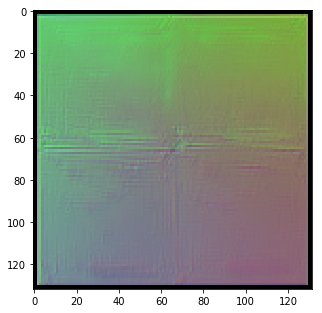

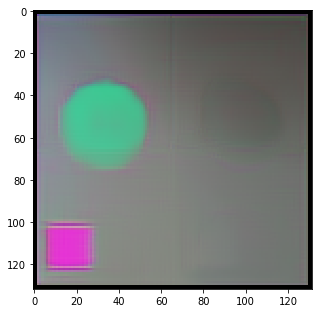

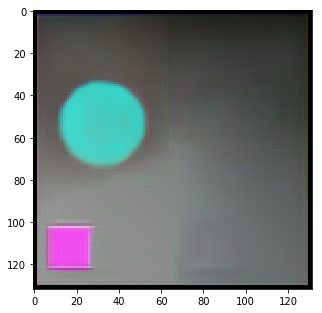

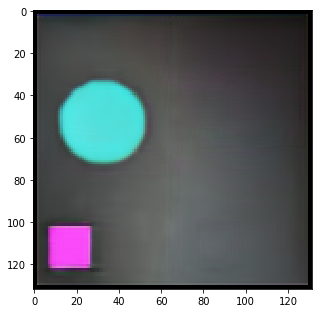

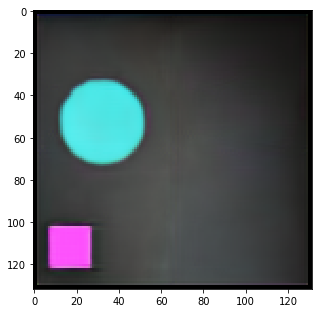

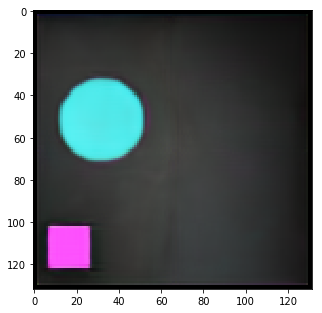

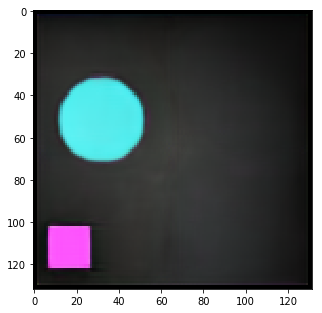

KeyboardInterrupt: 

In [11]:
train_with_video.run()

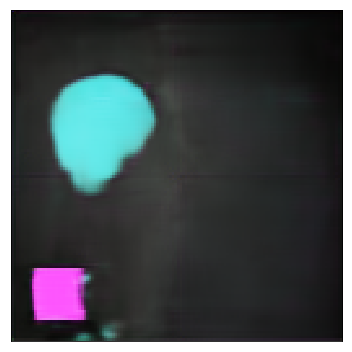

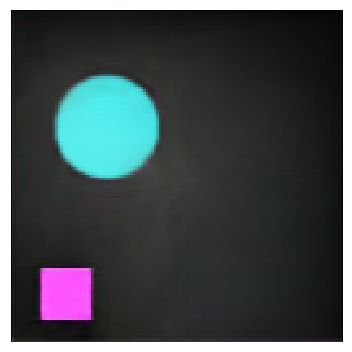

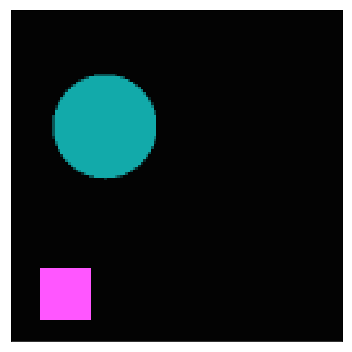

In [12]:
train_with_video.save_result();

In [13]:
train_with_video.path_ +"/fit.mp4"

'experiment_results/26_Mar_2018:16:03:14/fit.mp4'

In [14]:
%%HTML
<video width="320" height="240" controls loop>
  <source src='experiment_results/26_Mar_2018:16:03:14/fit.mp4' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='experiment_results/26_Mar_2018:16:03:14/predict.mp4' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='experiment_results/26_Mar_2018:16:03:14/target.mp4' type="video/mp4">
</video>

In [19]:
torch.save(net.state_dict(), train_with_video.path_ + '/net_state.dict')
for key in spatial_maps_generator.spatial_variables:
    torch.save(spatial_maps_generator.spatial_variables[key], train_with_video.path_ + '/{}.dict'.format(key))

# Continue training with picture

In [117]:
net.load_state_dict(torch.load(train_with_video.path_ + '/net_state.dict'))

In [118]:
from utils.common_utils import plotCircle, plotRectangle
import numpy as np

back_side = np.zeros((256, 256, 3))
image = plotCircle(back_side, vertex=(40, 40), size=40, color=(0.3, 0.5, 0.2))
image = plotRectangle(image, vertex=(200, 40), size=30, color=(0.7, 0.1, 0.1))
image = np.array([image])

config = {
    "PLOT": True,
    "optimizer": "adam",
    "lr": 1e-2,
    "num_iter": 2000,
    "show_every": 100,
    "maps_number": 4,
    "input_size": 128,
    "output_size": 128,
    "video_length": 1
}

target = preprocessTarget(image, config["video_length"], config["output_size"])
batch_generator = BatchGenerator(target, spatial_maps_generator, config[
                                 "input_size"], config["input_size"])

parameters = list(net.context.parameters())[-18:]
train_with_picture = Experiment(config, parameters, batch_generator, net, loss)

Starting optimization with ADAM


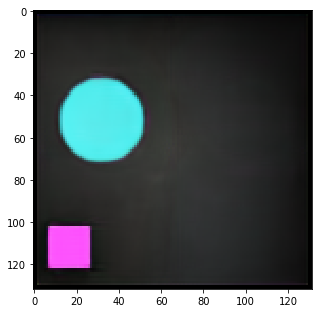

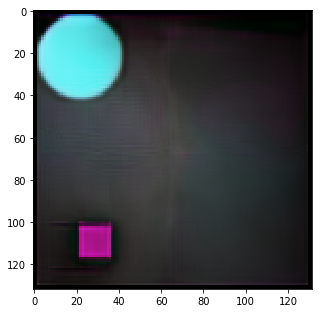

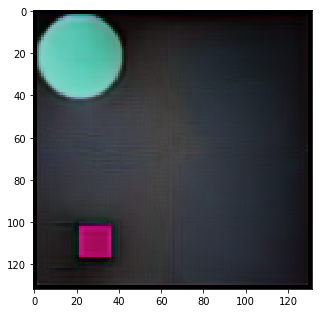

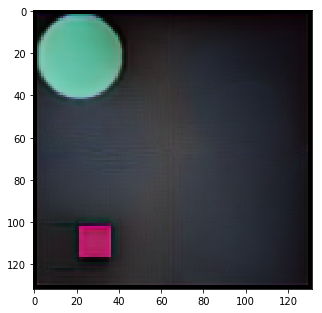

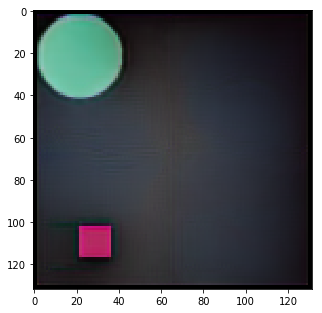

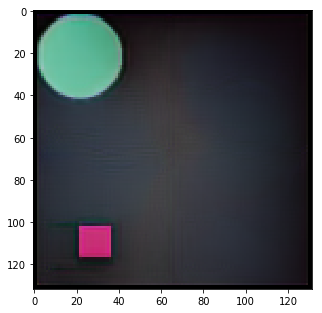

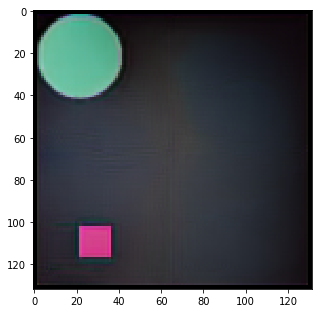

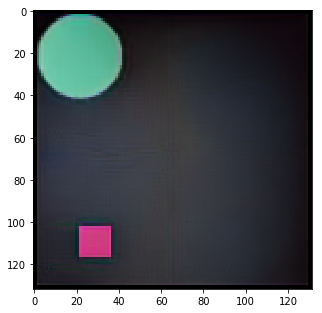

KeyboardInterrupt: 

In [119]:
train_with_picture.run()

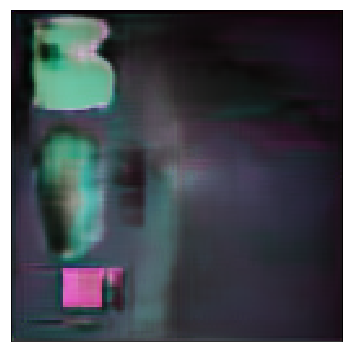

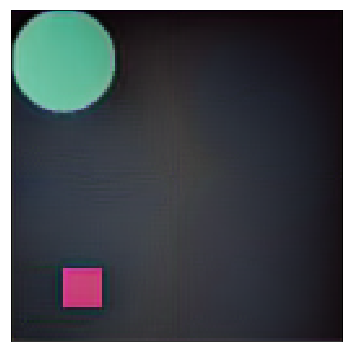

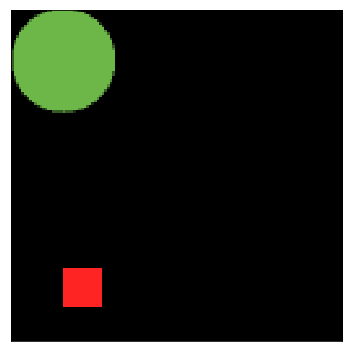

In [120]:
train_with_picture.save_result()

In [121]:
from IPython.core.display import display, HTML
display(HTML(''' <video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video> '''.format(train_with_picture.path_ +"/fit.mp4",
                    train_with_picture.path_ +"/predict.mp4",
                    train_with_picture.path_ +"/target.mp4")))